In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

import bilby
from bilby.gw import utils as gwutils
from pesummary.gw.conversions import spins as pespin
from multiprocessing import Pool
import multiprocessing
from functools import partial
from bilby.gw import conversion

import torch
import os
# cit: '/home/qian.hu/neuron_process_waveform/npf_GWwaveform'
# local: '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/'
try:
    os.chdir('/home/qian.hu/neuron_process_waveform/npf_GWwaveform/')
except:
    os.chdir('/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/')
from gw.utils import gwutils as npgwutils
from npf.utils.helpers import rescale_range

import logging

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Single waveform context

In [22]:
duration=32/4
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 1,
 'a_1': 0.48817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomXPHM' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SEOBNRv4PHM' # SEOBNRv4PHM SEOBNRv4P
f_ref = 50
f_lower = 20
waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments_under = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

waveform_generator_under = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments_under)

In [23]:
h_dict_imr = waveform_generator.frequency_domain_strain(injection_parameters)
h_dict_eob = waveform_generator_under.frequency_domain_strain(injection_parameters)

In [24]:
# local
path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

# cit
path_cit_PHM = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

np_model_path = path_local_PHM
waveform_generator_np = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                      context_waveform_generator=waveform_generator,device='cpu')

waveform_generator_np2 = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                       context_waveform_generator=waveform_generator_under,device='cpu')


--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 95 | train loss: 8215.8128 | valid loss: 9618.0331 | test log likelihood: -8821.4857

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 95 | train loss: 8525.2475 | valid loss: 9923.1221 | test log likelihood: -9354.2217

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 87 | train loss: 10729.9055 | valid loss: 12006.9353 | test log likelihood: -11772.4798

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 97 | train loss: 11306.5291 | valid loss: 12728.3657 | test log likelihood: -12339.914

--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 95 | train loss: 8215.8128 | valid loss: 9618.0331 | test log likelihood: -8821.4857

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 95 | train loss: 8525.2475 | valid loss: 9923.1221 | test log likelihood: -9354.2217



In [25]:
h_dict, error_dict = waveform_generator_np.frequency_domain_strain(injection_parameters)

h_dict2, error_dict2 = waveform_generator_np2.frequency_domain_strain(injection_parameters)

/Users/qianhu/opt/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [26]:
for key in ['plus', 'cross']:
    h_dict_eob[key] = npgwutils.get_shifted_h2_zeropad(h_dict_imr[key], h_dict_eob[key], det)

(20.0, 40.0)

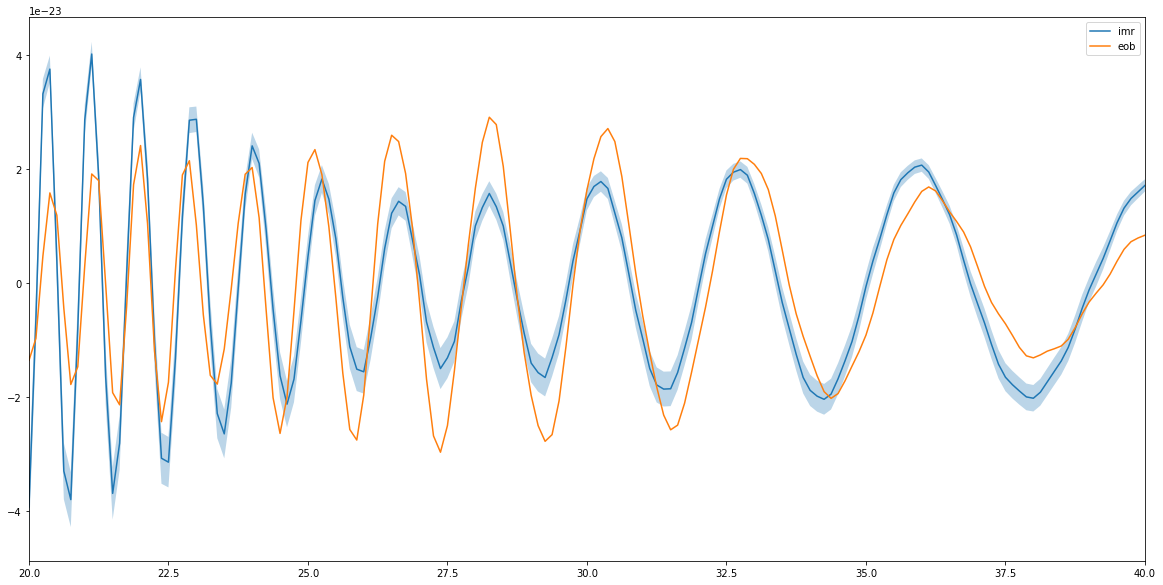

In [27]:
plt.figure(figsize=(20,10))

mode = 'cross'
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict[mode]), label='np')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                 alpha=0.3 )
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict_imr[mode]), label='imr')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
                 alpha=0.3 )

plt.plot(waveform_generator.frequency_array, np.real(h_dict_eob[mode]), label='eob')

plt.legend()
#plt.xlim(40,100)
plt.xlim(20,40)

(20, 2000)

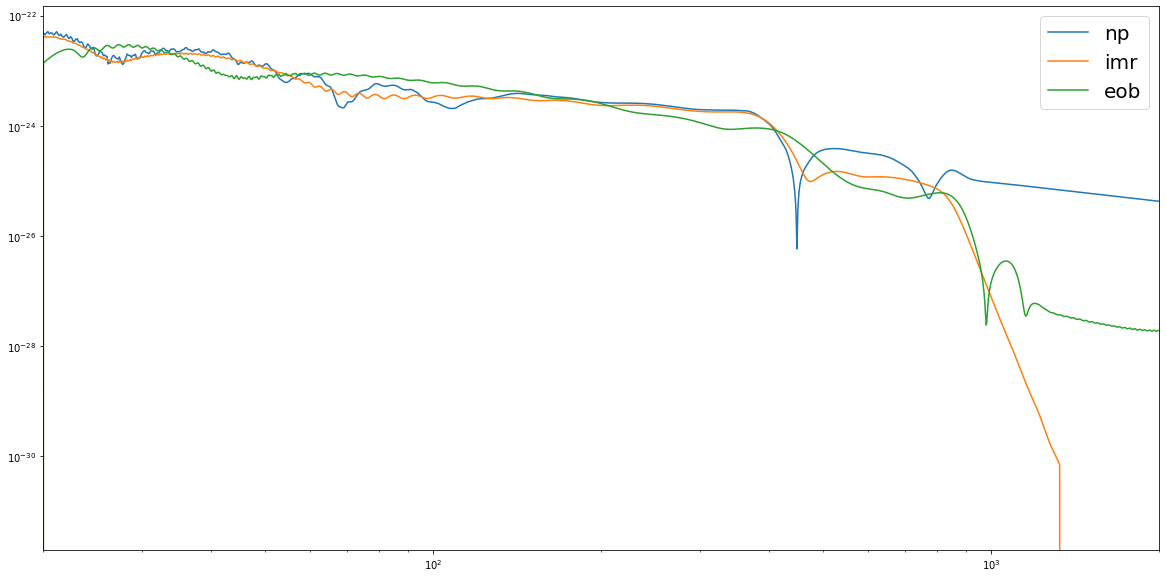

In [28]:
plt.figure(figsize=(20,10))

mode = 'cross'
plt.loglog(waveform_generator.frequency_array, np.abs(h_dict[mode]), label='np')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_imr[mode]), label='imr')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_eob[mode]), label='eob')

plt.legend(fontsize=20)
plt.xlim(20,2000)

(20.0, 50.0)

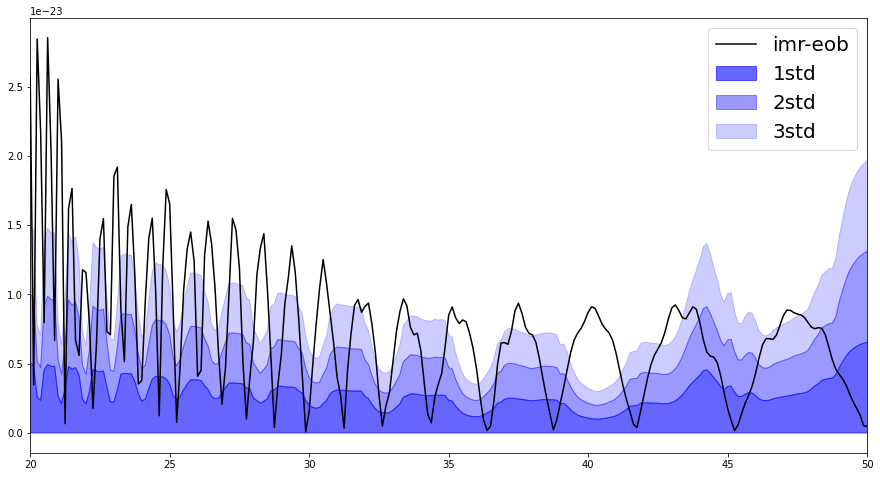

In [29]:
plt.figure(figsize=(15,8))

mode = 'cross'


plt.plot(waveform_generator.frequency_array, abs(np.real(h_dict_imr[mode]-h_dict_eob[mode])), label='imr-eob', color='k')

plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

In [30]:
for key, errors in error_dict2.items():
    error_dict2[key] = npgwutils.get_shifted_h2_zeropad(error_dict[key], error_dict2[key], det)

(20.0, 50.0)

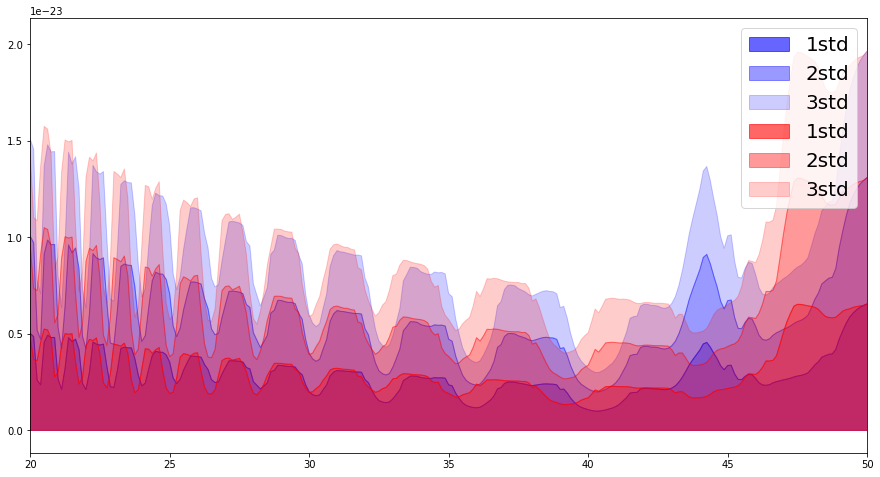

In [31]:
plt.figure(figsize=(15,8))

mode = 'cross'
plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict2[mode]), label=f'1std', alpha=0.6, color='r')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict2[mode]),2*np.real(error_dict2[mode]), alpha=0.4, color='r', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict2[mode]),3*np.real(error_dict2[mode]), label=f'3std', alpha=0.2, color='r')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

In [16]:
len(waveform_generator.frequency_array,)

8193

# Mix test

In [118]:
bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(15.415,0.4)

40.000109211914115

In [11]:
duration=32
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 0.4,
 'a_1': 0.58817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

injection_parameters_train = {'chirp_mass': 15.415,
 'mass_ratio': 0.4,
 'a_1': 0.58817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomPv2' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SEOBNRv4P' # SEOBNRv4PHM SEOBNRv4P
f_ref = 50
f_lower = 20
waveform_arguments1 = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments2 = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments1)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments2)

In [12]:
import time

def scale_waveform(target_mass, base_f, base_h, base_mass):
    mratio = target_mass/base_mass
    target_f = base_f / mratio
    target_h = base_h * mratio**2

    return target_f, target_h

def monochromatize_waveform(farray, harray, chirp_mass):
    c=299792458
    G=6.67e-11
    A=(np.pi)**(-2/3)*np.sqrt(5/24)
    amp = A*c*(G*chirp_mass/c**3)**(5/6) * farray**(-7/6)
    h_mono = harray / amp
    f_mono = farray**(-5/3) * 1e3

    return f_mono, h_mono

def unmonochromatize_waveform(f_mono, h_mono, chirp_mass):
    c=299792458
    G=6.67e-11
    A=(np.pi)**(-2/3)*np.sqrt(5/24)
    farray = (f_mono/1e3)**(-3/5)
    amp = A*c*(G*chirp_mass/c**3)**(5/6) * farray**(-7/6)
    harray = h_mono * amp

    return farray, harray

def resample_mono_fdwaveforms(f_mono, h_mono):
    f_mono_new = f_mono[::-1]
    h_mono_new = h_mono[::-1]

    fs_min = min(f_mono_new)
    fs_max = max(f_mono_new)

    fs_rd = 0.1 # for M=25, ringfown freq=0.015. Take 0.02 here
    new_fs1 = np.linspace(fs_min, fs_rd, int(len(f_mono_new)*fs_rd/(fs_max-fs_min)) )
    new_fs2 = np.linspace(fs_rd, fs_max, len(f_mono_new)//10)
    new_fs = np.append(new_fs1,new_fs2[1:])

    interpolator = scipy.interpolate.CubicSpline(f_mono_new, h_mono_new)
    new_h = interpolator(new_fs)

    #return new_fs[::-1], new_h[::-1]
    return new_fs, new_h

def unresample_mono_fdwaveforms(f_mono_resampled, h_mono_resampled, f_mono):
    interpolator = scipy.interpolate.CubicSpline(f_mono_resampled[::-1], h_mono_resampled[::-1])
    h_mono = interpolator(f_mono)
    return h_mono


def mix_waveforms(farray, h1_dict, h2_dict, mode, part, fraction=0.01, probe=False):
    #length = len(h1_dict['plus'][mask])
    #index1 = np.random.permutation(length)[:int(length*weight)]
    #index2 = np.random.permutation(length)[:length-int(length*weight)]
    #index1 = np.arange(length)[::2]
    #index2 = np.arange(length)[1::2]
    #argsort = np.argsort(np.append(index1, index2))

    l = len(farray)
    
    farray_m1to1 = rescale_range(farray, (farray.min(),farray.max()), (-1,1))
    ctxtindex = np.arange(0,l,int(1/fraction))
    ffarray = np.array(list(zip(farray_m1to1[ctxtindex], farray_m1to1[ctxtindex]))).flatten()
    if part == 'real':
        if probe:
            return ffarray, np.real(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten()),\
                    np.array(list(zip(farray[ctxtindex], farray[ctxtindex]))).flatten()
        else:
            return ffarray, np.real(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten())
    elif part == 'imag':
        if probe:
            return ffarray, np.real(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten()),\
                    np.array(list(zip(farray[ctxtindex], farray[ctxtindex]))).flatten()
        else:
            return ffarray, np.imag(np.array(list(zip(h1_dict[mode][ctxtindex], h2_dict[mode][ctxtindex]))).flatten())

In [13]:
t0=time.time()
mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(
            injection_parameters['chirp_mass'],
            injection_parameters['mass_ratio']
        )
npmodel_total_mass=40
mratio = mtot/npmodel_total_mass

#waveform_generator1.waveform_arguments['minimum_frequency'] /= mratio
#waveform_generator2.waveform_arguments['minimum_frequency'] /= mratio

fmin4inj = waveform_generator1.waveform_arguments['minimum_frequency']
context_f_low = 20
waveform_generator1.waveform_arguments['minimum_frequency'] = context_f_low
waveform_generator2.waveform_arguments['minimum_frequency'] = context_f_low

waveform_generator1.waveform_arguments['reference_frequency'] *= mratio
waveform_generator2.waveform_arguments['reference_frequency'] *= mratio

#if fmin4inj>context_f_low: 
#    logging.warning(f"Mtot={mtot} < Training Mtot {npmodel_total_mass}, therefore changing starting frequency to {fmin4inj}Hz, which is higher than given {context_f_low}Hz.")


context_frequency_array = waveform_generator1.frequency_array
mask = context_frequency_array>=fmin4inj
d_l = injection_parameters['luminosity_distance']
injection_parameters['luminosity_distance'] = 100
injection_parameters['chirp_mass'] = injection_parameters['chirp_mass']/mratio
print("new mc", injection_parameters['chirp_mass'])

h_dict_context1 = waveform_generator1.frequency_domain_strain(injection_parameters)
h_dict_context2 = waveform_generator2.frequency_domain_strain(injection_parameters)
t1=time.time()

for key, errors in h_dict_context2.items():
    h_dict_context2[key] = npgwutils.get_shifted_h2_zeropad(h_dict_context1[key], h_dict_context2[key], det)
t2=time.time()

farray0 = context_frequency_array[mask]
probe_h = h_dict_context1['cross'][mask]

hmono_dict_context1 = {}
hmono_dict_context2 = {}
for mode2scale in ['plus','cross']:
    # mask
    h_dict_context1[mode2scale] = h_dict_context1[mode2scale][mask]
    h_dict_context2[mode2scale] = h_dict_context2[mode2scale][mask]


    # scale to training mass
    #scaled_context_f, h_dict_context1[mode2scale] = scale_waveform(target_mass=npmodel_total_mass, base_f=farray0, base_h=h_dict_context1[mode2scale], base_mass=mtot)
    #scaled_context_f, h_dict_context2[mode2scale] = scale_waveform(target_mass=npmodel_total_mass, base_f=farray0, base_h=h_dict_context2[mode2scale], base_mass=mtot)

    # monochromatize
    f_mono, hmono_dict_context1[mode2scale] = monochromatize_waveform(farray0, h_dict_context1[mode2scale], injection_parameters['chirp_mass'])
    f_mono, hmono_dict_context2[mode2scale] = monochromatize_waveform(farray0, h_dict_context2[mode2scale], injection_parameters['chirp_mass'])

    probh1 = h_dict_context1[mode2scale]
    # resample
    f_mono_resampled, h1_mono_resampled_real = resample_mono_fdwaveforms(f_mono, np.real(hmono_dict_context1[mode2scale]))
    f_mono_resampled, h1_mono_resampled_imag = resample_mono_fdwaveforms(f_mono, np.imag(hmono_dict_context1[mode2scale]))
    h_dict_context1[mode2scale] = h1_mono_resampled_real + h1_mono_resampled_imag*1j
    
    f_mono_resampled, h2_mono_resampled_real = resample_mono_fdwaveforms(f_mono, np.real(hmono_dict_context2[mode2scale]))
    f_mono_resampled, h2_mono_resampled_imag = resample_mono_fdwaveforms(f_mono, np.imag(hmono_dict_context2[mode2scale]))
    h_dict_context2[mode2scale] = h2_mono_resampled_real + h2_mono_resampled_imag*1j
    


h_dict_context_components={}
context_fraction = 0.3
ff_mono_resampled, h_dict_context_components['plus_real'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'plus', 'real', context_fraction)
ff_mono_resampled, h_dict_context_components['plus_imag'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'plus', 'imag', context_fraction)
ff_mono_resampled, h_dict_context_components['cross_real'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'cross', 'real', context_fraction)
ff_mono_resampled, h_dict_context_components['cross_imag'],cnmf = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'cross', 'imag', context_fraction,True)


model_path = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0221_5percent/"
model_path = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0215_2/"
npmodel_dict = npgwutils.get_trained_gwmodels(model_path,device='cpu')




new mc 15.41495791257351

--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 53 | train loss: 963.8841 | valid loss: 5833.8574 | test log likelihood: -11169.7719

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 53 | train loss: 1405.9768 | valid loss: 6278.9118 | test log likelihood: -12922.3249

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 53 | train loss: 5844.2346 | valid loss: 10770.8468 | test log likelihood: -15702.9021

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 72 | train loss: 5302.8279 | valid loss: 14434.7345 | test log likelihood: -19813.4421


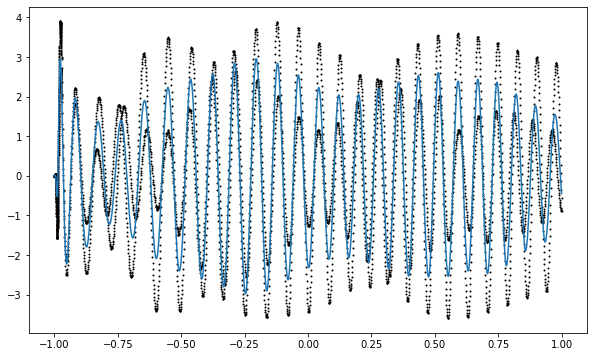

In [14]:

mean_dict={}
std_dict={}
label = 'cross_imag'
h_mono_resampled = h_dict_context_components[label]
#for label,h_mono_resampled in h_dict_context_components.items():
model = npmodel_dict[label]
t3 = time.time()

target_f_mono_resampled = rescale_range(f_mono_resampled, (f_mono_resampled.min(),f_mono_resampled.max()), (-1,1))
mean_resampled, std_resampled = npgwutils.get_predictions(model,
                                    torch.from_numpy(ff_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                    torch.from_numpy(h_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                    torch.from_numpy(target_f_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                    1)

t4 = time.time()

farray2, mean_scaled = unmonochromatize_waveform(f_mono_resampled[::-1], mean_resampled[::-1], injection_parameters['chirp_mass'])
farray2, std_scaled = unmonochromatize_waveform(f_mono_resampled[::-1], std_resampled[::-1], injection_parameters['chirp_mass'])

# unscale to injection mass
# farray3 should == farray (?)
farray3, mean = scale_waveform(target_mass=mtot, base_f=farray2, base_h=mean_scaled, base_mass=npmodel_total_mass)
farray3, std = scale_waveform(target_mass=mtot, base_f=farray2, base_h=std_scaled, base_mass=npmodel_total_mass)
#print(farray3)
interpolator_mean = scipy.interpolate.CubicSpline(farray3, mean)
mean_at_freq = interpolator_mean(context_frequency_array[mask])

interpolator_std = scipy.interpolate.CubicSpline(farray3, std)
std_at_freq = interpolator_std(context_frequency_array[mask])

#zerolenth = len(np.where(context_frequency_array<min(fmin4inj,context_f_low))[0])
zerolenth = len(np.where(context_frequency_array<fmin4inj)[0])
zero_paddings = np.zeros(zerolenth)

mean_dict[label] = np.append(zero_paddings, mean_at_freq) * 100 / d_l
#mean_dict[label] = mean_resampled
std_dict[label] = np.append(zero_paddings, std_at_freq) * 100 / d_l

plt.figure(figsize=(10,6))
plt.scatter(ff_mono_resampled, h_mono_resampled, color='k', s=1)
plt.plot(target_f_mono_resampled, mean_resampled)
plt.show()

h_dict = {}
error_dict = {}
#for key in ['plus', 'cross']:
#    h_dict[key] = mean_dict[f'{key}_real'] + mean_dict[f'{key}_imag']*1j
#    error_dict[key] = std_dict[f'{key}_real'] + std_dict[f'{key}_imag']*1j
    

#waveform_generator1.waveform_arguments['minimum_frequency'] *= mratio
#waveform_generator2.waveform_arguments['minimum_frequency'] *= mratio
injection_parameters['luminosity_distance']=d_l
injection_parameters['chirp_mass'] = injection_parameters['chirp_mass']*mratio
waveform_generator1.waveform_arguments['reference_frequency'] /= mratio
waveform_generator2.waveform_arguments['reference_frequency'] /= mratio
tend = time.time()
#print(f"context waveform time cost: {t1-t0}s")
#print(f"shifting waveform time cost: {t2-t1}s")
#print(f"prediction time cost: {4*(t4-t3)}s")

#print(f"total time cost: {tend-t0}s")

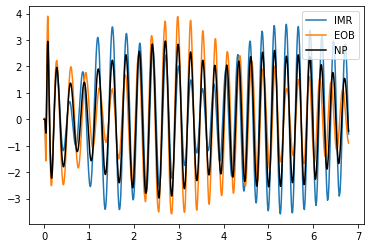

In [25]:
plt.plot(f_mono, hmono_dict_context1[mode2scale], label='IMR')
plt.plot(f_mono, hmono_dict_context2[mode2scale], label='EOB')
plt.plot(f_mono_resampled, mean_resampled, label='NP', color='k')
plt.legend()


In [37]:
farray2test, unmonotest1 = unmonochromatize_waveform(f_mono, hmono_dict_context1[mode2scale], injection_parameters['chirp_mass']/mratio)
farray2test, unmonotest2 = unmonochromatize_waveform(f_mono, hmono_dict_context2[mode2scale], injection_parameters['chirp_mass']/mratio)


In [39]:
farray3test, scaledtest1 = scale_waveform(target_mass=mtot, base_f=farray2test, base_h=unmonotest1, base_mass=npmodel_total_mass)
farray3test, scaledtest2 = scale_waveform(target_mass=mtot, base_f=farray2test, base_h=unmonotest2, base_mass=npmodel_total_mass)


In [8]:
mode = 'cross'
plot_wave1 = waveform_generator1.frequency_domain_strain(injection_parameters)[mode]
plot_wave2 = waveform_generator2.frequency_domain_strain(injection_parameters)[mode]
plot_wave2 = npgwutils.get_shifted_h2_zeropad(plot_wave1, plot_wave2, det)

In [65]:
waveform_generator1>=20

array([  20.     ,   20.03125,   20.0625 , ..., 2047.9375 , 2047.96875,
       2048.     ])

In [66]:
f1, h1 = monochromatize_waveform(farray0, plot_wave1[mask], injection_parameters['chirp_mass'])



In [70]:
f11, h11 = unmonochromatize_waveform(f1, h1, injection_parameters['chirp_mass'])

(10.0, 50.0)

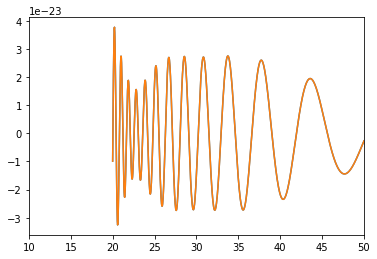

In [73]:
plt.plot(f11, h11)
plt.plot(farray0, plot_wave1[mask])

plt.xlim(10,50)

/Users/qianhu/opt/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


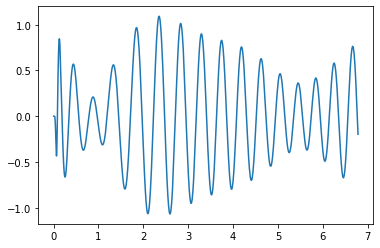

In [67]:
plt.plot(f1, h1)

In [9]:
plt.figure(figsize=(10,6))
plt.loglog(waveform_generator1.frequency_array, abs(h_dict[mode]),label='NP')
plt.loglog(waveform_generator1.frequency_array, abs(plot_wave1),label='IMR')
plt.loglog(waveform_generator2.frequency_array, abs(plot_wave2),label='EOB')

plt.loglog(farray0_scaled, abs(probe_h_scaled/3.2), label='probe scaled', linestyle='--')
plt.xlim(10,2048)

plt.legend()


KeyError: 'cross'

<Figure size 720x432 with 0 Axes>

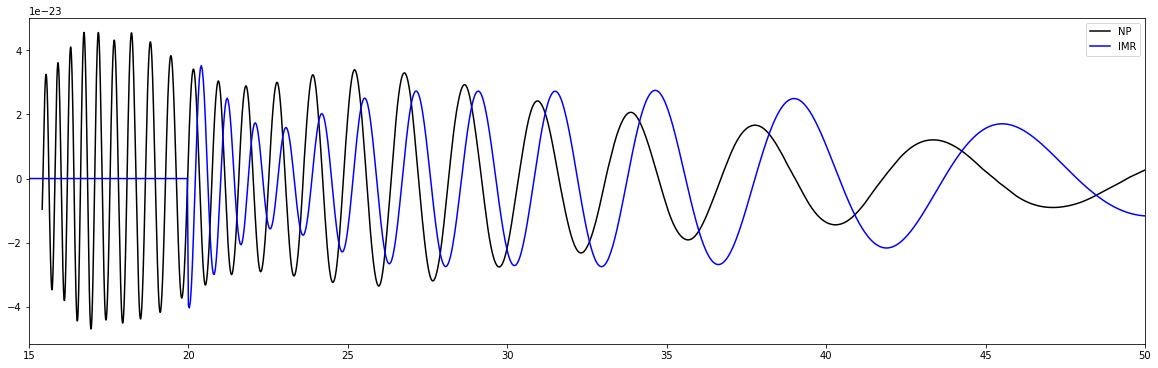

In [16]:
plt.figure(figsize=(20,6))
#plt.plot(waveform_generator1.frequency_array, np.imag(h_dict[mode]),label='NP',color='k')
#plt.plot(context_frequency_array[mask], mean_at_freq/3.2,label='NP',color='k')
#plt.fill_between(waveform_generator1.frequency_array, np.imag(h_dict['cross']-error_dict['cross']),np.imag(h_dict['cross']+error_dict['cross']),
#                 label='NP 1 sigma',color='k', alpha=0.2)

plt.plot(farray3, mean/3.2,label='NP',color='k')
plt.plot(waveform_generator1.frequency_array, np.imag(plot_wave1),label='IMR',color='b')
#plt.plot(waveform_generator2.frequency_array, np.imag(plot_wave2),label='EOB',color='r')
#plt.plot(farray3test, scaledtest1,label='scaled 1')
#plt.plot(farray3test, scaledtest2,label='scaled 2')

#plt.plot(farray0_scaled, np.imag(probe_h_scaled/3.2), label='shifted test', color='y', linestyle='--')
#plt.plot(farray3, mean*100 / d_l , label='fuck',linestyle='--',color='g')
plt.xlim(15,50)

#plt.xlim(400,2000)
#plt.ylim(-1e-25,1e-25)
plt.legend()


(10.0, 50.0)

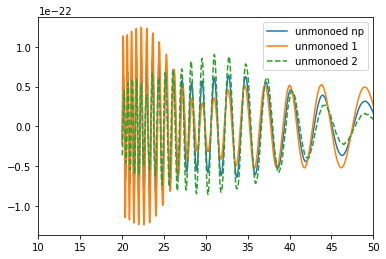

In [38]:
plt.plot(farray2, mean_scaled,label='unmonoed np')

plt.plot(farray2test, unmonotest1,label='unmonoed 1')
plt.plot(farray2test, unmonotest2,label='unmonoed 2',linestyle='--')

#plt.plot(farray0, probe_h,linestyle='--',)
#plt.plot(waveform_generator1.frequency_array, np.real(h_dict[mode]),label='NP',color='k')
plt.legend()
plt.xlim(10,50)

(10.0, 50.0)

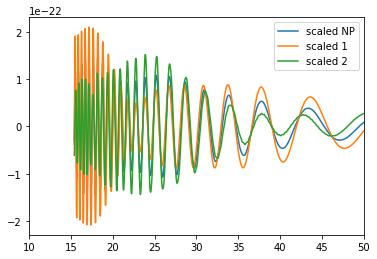

In [53]:
plt.plot(farray3, mean,label='scaled NP')
plt.plot(farray3test, scaledtest1,label='scaled 1')
plt.plot(farray3test, scaledtest2,label='scaled 2')

#plt.plot(context_frequency_array[mask], mean_at_freq,label='NP',color='k')
plt.legend()

plt.xlim(10,50)

(10.0, 50.0)

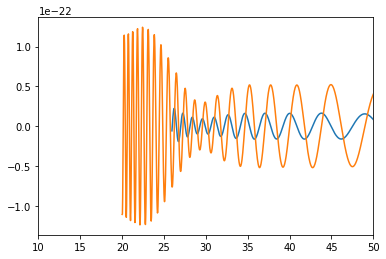

In [56]:
plt.plot(backscaled_freq, backscaled_h1, label='back scaled 1')
plt.plot(farray0, np.imag(probh1), label='ori 1')
plt.xlim(10,50)

In [121]:
t0=time.time()
mtot = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(
            injection_parameters['chirp_mass'],
            injection_parameters['mass_ratio']
        )
npmodel_total_mass=40
mratio = mtot/npmodel_total_mass

waveform_generator1.waveform_arguments['minimum_frequency'] /= mratio
waveform_generator2.waveform_arguments['minimum_frequency'] /= mratio

fmin4inj = waveform_generator1.waveform_arguments['minimum_frequency']
context_f_low = 20
if fmin4inj>context_f_low: 
    logging.warning(f"Mtot={mtot} < Training Mtot {npmodel_total_mass}, therefore changing starting frequency to {fmin4inj}Hz, which is higher than given {context_f_low}Hz.")


context_frequency_array = waveform_generator1.frequency_array
mask = context_frequency_array>=fmin4inj
d_l = injection_parameters['luminosity_distance']
injection_parameters['luminosity_distance'] = 100
h_dict_context1 = waveform_generator1.frequency_domain_strain(injection_parameters)
h_dict_context2 = waveform_generator2.frequency_domain_strain(injection_parameters)
t1=time.time()

for key, errors in h_dict_context2.items():
    h_dict_context2[key] = npgwutils.get_shifted_h2_zeropad(h_dict_context1[key], h_dict_context2[key], det)
t2=time.time()

farray0 = context_frequency_array[mask]
for mode2scale in ['plus','cross']:
    # mask
    h_dict_context1[mode2scale] = h_dict_context1[mode2scale][mask]
    h_dict_context2[mode2scale] = h_dict_context2[mode2scale][mask]

    # scale to training mass
    scaled_context_f, h_dict_context1[mode2scale] = scale_waveform(target_mass=npmodel_total_mass, base_f=farray0, base_h=h_dict_context1[mode2scale], base_mass=mtot)
    scaled_context_f, h_dict_context2[mode2scale] = scale_waveform(target_mass=npmodel_total_mass, base_f=farray0, base_h=h_dict_context2[mode2scale], base_mass=mtot)

    # monochromatize
    f_mono, h_dict_context1[mode2scale] = monochromatize_waveform(scaled_context_f, h_dict_context1[mode2scale], injection_parameters['chirp_mass']/mratio)
    f_mono, h_dict_context2[mode2scale] = monochromatize_waveform(scaled_context_f, h_dict_context2[mode2scale], injection_parameters['chirp_mass']/mratio)

    # resample
    f_mono_resampled, h1_mono_resampled_real = resample_mono_fdwaveforms(f_mono, np.real(h_dict_context1[mode2scale]))
    f_mono_resampled, h1_mono_resampled_imag = resample_mono_fdwaveforms(f_mono, np.imag(h_dict_context1[mode2scale]))
    h_dict_context1[mode2scale] = h1_mono_resampled_real + h1_mono_resampled_imag*1j
    f_mono_resampled, h2_mono_resampled_real = resample_mono_fdwaveforms(f_mono, np.real(h_dict_context2[mode2scale]))
    f_mono_resampled, h2_mono_resampled_imag = resample_mono_fdwaveforms(f_mono, np.imag(h_dict_context2[mode2scale]))
    h_dict_context2[mode2scale] = h2_mono_resampled_real + h2_mono_resampled_imag*1j
    

h_dict_context_components={}
context_fraction = 0.3
ff_mono_resampled, h_dict_context_components['plus_real'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'plus', 'real', context_fraction)
ff_mono_resampled, h_dict_context_components['plus_imag'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'plus', 'imag', context_fraction)
ff_mono_resampled, h_dict_context_components['cross_real'] = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'cross', 'real', context_fraction)
ff_mono_resampled, h_dict_context_components['cross_imag'],cnmf = mix_waveforms(f_mono_resampled, h_dict_context1, h_dict_context2, 'cross', 'imag', context_fraction,True)


model_path = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0221_5percent/"
model_path = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0215_2/"
npmodel_dict = npgwutils.get_trained_gwmodels(model_path,device='cpu')


mean_dict={}
std_dict={}
for label,h_mono_resampled in h_dict_context_components.items():
    model = npmodel_dict[label]
    t3 = time.time()
    
    target_f_mono_resampled = rescale_range(f_mono_resampled, (f_mono_resampled.min(),f_mono_resampled.max()), (-1,1))
    mean_resampled, std_resampled = npgwutils.get_predictions(model,
                                        torch.from_numpy(ff_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                        torch.from_numpy(h_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                        torch.from_numpy(target_f_mono_resampled).unsqueeze(-1).unsqueeze(0).type(torch.float32), 
                                        1)
    t4 = time.time()
    #mean_resampled = mean_resampled[::-1]
    #std_resampled = std_resampled[::-1]
    #mean_mono = self.unresample_mono_fdwaveforms(f_mono_resampled, mean_resampled, f_mono)
    #std_mono = self.unresample_mono_fdwaveforms(f_mono_resampled, std_resampled, f_mono)

    #mean_resampled = mean_resampled[::2]
    #std_resampled = std_resampled[::2]

    farray2, mean_scaled = unmonochromatize_waveform(f_mono_resampled, mean_resampled, injection_parameters['chirp_mass']/mratio)
    farray2, std_scaled = unmonochromatize_waveform(f_mono_resampled, std_resampled, injection_parameters['chirp_mass']/mratio)

    # unscale to injection mass
    # farray3 should == farray (?)
    farray3, mean = scale_waveform(target_mass=mtot, base_f=farray2, base_h=mean_scaled, base_mass=npmodel_total_mass)
    farray3, std = scale_waveform(target_mass=mtot, base_f=farray2, base_h=std_scaled, base_mass=npmodel_total_mass)
    #print(farray3)
    interpolator_mean = scipy.interpolate.CubicSpline(farray3[::-1], mean[::-1])
    mean_at_freq = interpolator_mean(context_frequency_array[mask])

    interpolator_std = scipy.interpolate.CubicSpline(farray3[::-1], std[::-1])
    std_at_freq = interpolator_std(context_frequency_array[mask])

    #zerolenth = len(np.where(context_frequency_array<min(fmin4inj,context_f_low))[0])
    zerolenth = len(np.where(context_frequency_array<fmin4inj)[0])
    zero_paddings = np.zeros(zerolenth)

    mean_dict[label] = np.append(zero_paddings, mean_at_freq) * 100 / d_l
    #mean_dict[label] = mean_resampled
    std_dict[label] = np.append(zero_paddings, std_at_freq) * 100 / d_l

h_dict = {}
error_dict = {}
for key in ['plus', 'cross']:
    h_dict[key] = mean_dict[f'{key}_real'] + mean_dict[f'{key}_imag']*1j
    error_dict[key] = std_dict[f'{key}_real'] + std_dict[f'{key}_imag']*1j
    

waveform_generator1.waveform_arguments['minimum_frequency'] *= mratio
waveform_generator2.waveform_arguments['minimum_frequency'] *= mratio
injection_parameters['luminosity_distance']=d_l

tend = time.time()
print(f"context waveform time cost: {t1-t0}s")
print(f"shifting waveform time cost: {t2-t1}s")
print(f"prediction time cost: {4*(t4-t3)}s")

print(f"total time cost: {tend-t0}s")



--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 53 | train loss: 963.8841 | valid loss: 5833.8574 | test log likelihood: -11169.7719

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 53 | train loss: 1405.9768 | valid loss: 6278.9118 | test log likelihood: -12922.3249

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 53 | train loss: 5844.2346 | valid loss: 10770.8468 | test log likelihood: -15702.9021

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 72 | train loss: 5302.8279 | valid loss: 14434.7345 | test log likelihood: -19813.4421


/Users/qianhu/opt/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


context waveform time cost: 1.5550010204315186s
shifting waveform time cost: 3.4262092113494873s
prediction time cost: 1.2550640106201172s
total time cost: 8.820829153060913s


# Mix context

In [18]:
duration=32
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 0.4,
 'a_1': 0.58817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomPv2' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SEOBNRv4P' # SEOBNRv4PHM SEOBNRv4P
f_ref = 50
f_lower = 20
waveform_arguments1 = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments2 = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments1)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments2)

In [19]:
h_dict_imr = waveform_generator1.frequency_domain_strain(injection_parameters)
h_dict_eob = waveform_generator2.frequency_domain_strain(injection_parameters)

In [20]:
# local
path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'
path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0221_3percent/'

# cit
path_cit_PHM = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
#path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'
path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/run0211/'
np_model_path = path_local_P
waveform_generator_np_mix = npgwutils.NPMixWaveformGenerator(model_path=np_model_path,
                                                          context_waveform_generator1=waveform_generator1,
                                                          context_waveform_generator2=waveform_generator2,
                                                          example_det = det,
                                                          device='cpu')



--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 99 | train loss: 2922.9079 | valid loss: 6351.6746 | test log likelihood: -10887.0886

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 99 | train loss: 2802.2002 | valid loss: 5378.5871 | test log likelihood: -10579.3827

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 99 | train loss: 6572.4539 | valid loss: 8701.7566 | test log likelihood: -14220.862

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 95 | train loss: 6196.3814 | valid loss: 8851.3691 | test log likelihood: -14195.7655


In [21]:
t1 = time.time()
h_dict, error_dict = waveform_generator_np_mix.frequency_domain_strain(injection_parameters)
t2 = time.time()

print(f"Timecost: {t2-t1}s")

Timecost: 5.91665506362915s


In [22]:
for key in ['plus', 'cross']:
    h_dict_eob[key] = npgwutils.get_shifted_h2_zeropad(h_dict_imr[key], h_dict_eob[key], det)

(20.0, 100.0)

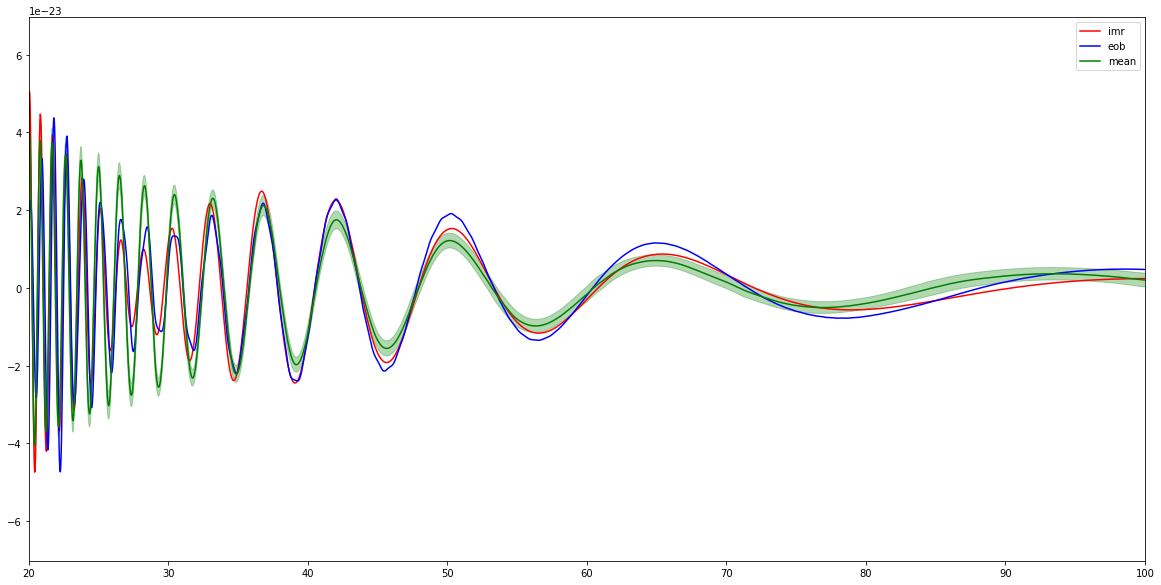

In [23]:
plt.figure(figsize=(20,10))

mode = 'plus'
part = 'real'

if part=='real':
    plt.plot(waveform_generator1.frequency_array, np.real(h_dict_imr[mode]), label='imr',color='r')
    plt.plot(waveform_generator2.frequency_array, np.real(h_dict_eob[mode]), label='eob',color='b')

    plt.plot(waveform_generator2.frequency_array, np.real(h_dict[mode]), label='mean',color='g')
    plt.fill_between(waveform_generator1.frequency_array,
                    np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                    alpha=0.3,color='g' )
elif part=='imag':
    plt.plot(waveform_generator1.frequency_array, np.imag(h_dict_imr[mode]), label='imr',color='r')
    plt.plot(waveform_generator2.frequency_array, np.imag(h_dict_eob[mode]), label='eob',color='b')

    plt.plot(waveform_generator2.frequency_array, np.imag(h_dict[mode]), label='mean',color='g')
    plt.fill_between(waveform_generator1.frequency_array,
                    np.imag(h_dict[mode]-error_dict[mode]),np.imag(h_dict[mode]+error_dict[mode]),
                    alpha=0.3,color='g' )


plt.legend()
#plt.xlim(40,100)
plt.xlim(20,100)

(20, 2000)

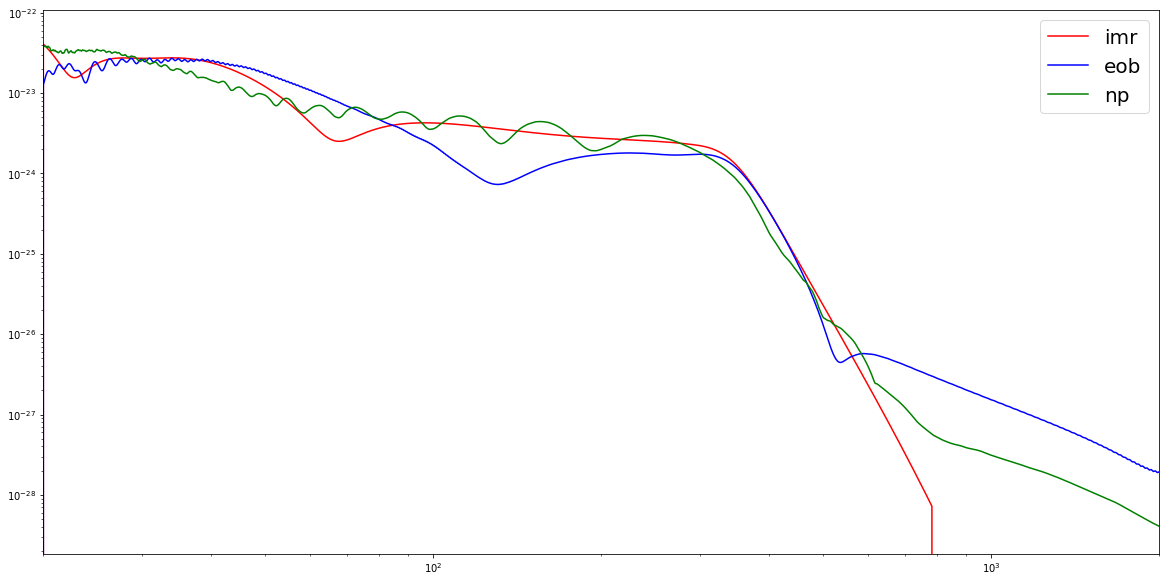

In [24]:
plt.figure(figsize=(20,10))

mode = 'cross'
plt.loglog(waveform_generator1.frequency_array, np.abs(h_dict_imr[mode]), label='imr',color='r')
plt.loglog(waveform_generator2.frequency_array, np.abs(h_dict_eob[mode]), label='eob',color='b')

plt.loglog(waveform_generator1.frequency_array, np.abs(h_dict[mode]), label='np',color='g')


plt.legend(fontsize=20)
plt.xlim(20,2000)